In [1]:
%%capture
!pip install mujoco==2.3.3


## **Importing Required Libraries**

This cell imports all the necessary libraries for implementing **Proximal Policy Optimization (PPO)**. The key components include:

In [2]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import torch.nn.functional as F

import torch.optim as optim
import gymnasium as gym
import numpy as np
import os
import pandas as pd

import imageio
from base64 import b64encode
from IPython.display import HTML


import logging
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
import numpy as np

if is_ipython:
    from IPython import display


## **Logging, Visualization, and Video Playback Functions**


In [3]:
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Memory Buffer for PPO**

### **Class: `Memory`**
- A **buffer** for storing experiences during training, used for **PPO (Proximal Policy Optimization) updates**.
- Stores the following per episode:
  - `actions`: Actions taken by the agent.
  - `states`: Observed states from the environment.
  - `logprobs`: Log probabilities of actions (needed for importance sampling in PPO).
  - `rewards`: Rewards obtained after taking actions.
  - `state_values`: Estimated state values from the critic.

### **Function: `clear()`**
- Clears the stored experiences before collecting new trajectories.
- Ensures memory is reset between updates to prevent stale data from affecting optimization.


In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Actor-Critic Network in PPO**

This implementation defines two neural networks used in Proximal Policy Optimization (PPO).

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.mu = nn.Linear(hidden_size, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim), requires_grad=True)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return F.tanh(self.mu(x)), torch.exp(self.log_std)

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim , hidden_size)
        self.value = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return self.value(x)

## **Proximal Policy Optimization (PPO) Algorithm Implementation**

This class implements the **PPO (Proximal Policy Optimization) algorithm**, which is a policy gradient method used in reinforcement learning. It optimizes an actor-critic network while maintaining stability and efficiency.

### **Key Components:**
1. **Initialization (`__init__`)**:
   - Sets hyperparameters (e.g., `gamma`, `eps_clip`, `gae_lambda`).
   - Creates **Actor and Critic networks**.
   - Defines **Adam optimizers** for both networks.
   - Initializes a memory buffer for storing experience.

2. **Action Selection (`select_action`)**:
   - Uses the **Actor network** to predict a mean and standard deviation for the action.
   - Samples an action from a normal distribution.
   - Stores the action, log probability, and value function output in memory.

3. **Policy Evaluation (`evaluate`)**:
   - Computes the log probability of actions under the current policy.
   - Returns entropy (used for exploration encouragement).

4. **Policy Update (`update`)**:
   - Computes **discounted rewards** and **Generalized Advantage Estimation (GAE)**.
   - Uses **clipped surrogate objective** to stabilize training.
   - Minimizes **actor loss** (policy update) and **critic loss** (value function update).
   - Updates networks using **gradient descent**.

5. **Memory Handling (`push_memory`, `load_memory`, `store_reward`)**:
   - Stores and retrieves experience for training updates.
   - Resets the memory buffer after each policy update.

### **Key Features of PPO**
- **Clipping Ratio**: Prevents excessive updates to the policy, improving stability.
- **Advantage Estimation**: Helps in reducing variance in policy updates.
- **Entropy Regularization**: Encourages exploration by adding entropy loss.


## **1. PPO Clipped Loss Function**
The PPO loss function prevents large policy updates by introducing a clipped objective. The ratio of new and old policy probabilities is computed as:
$$
r_t(\theta) = \frac{\pi_{\theta}(a_t | s_t)}{\pi_{\theta_{\text{old}}}(a_t | s_t)}
$$
where:
- $ \theta $ are the current policy parameters.
- $\theta_{\text{old}} $ are the policy parameters before the update.

The surrogate loss function is:
$$
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min \left( r_t(\theta) A_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t \right) \right]
$$
where:
- $ A_t $ is the **advantage function**, which measures how much better an action is compared to the expected value of the state.
- $ \epsilon $ is a small clipping parameter (e.g., **0.2**) that prevents drastic policy updates.

---

## **2. Critic Loss Function**
The critic is updated using **Mean Squared Error (MSE)** between the predicted and actual state value:
$$
L_{\text{critic}} = \mathbb{E} \left[ (V(s_t) - R_t)^2 \right]
$$

---

## **3. Total Loss**
The overall loss function is:
$$
L_{\text{total}} = L^{\text{CLIP}} + \beta H - L_{\text{critic}}
$$
where:
- $ H $ is the **entropy bonus** to encourage exploration.
- $ \beta $ is a small coefficient (e.g., **0.01**) controlling the strength of the entropy bonus.


In [11]:
class PPO(nn.Module):
    def __init__(self, env, config):
        super(PPO, self).__init__()
        self.gamma = config.GAMMA
        self.eps_clip = config.EPS_CLIP
        self.epochs = config.K_EPOCHS
        self.gae_lambda = config.GAE
        self.hidden_size = config.hidden_size

        self.lr = config.LEARNING_RATE
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.actor = Actor(state_dim, self.hidden_size, action_dim).to(device)
        self.critic = Critic(state_dim, self.hidden_size).to(device)

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)
        self.memory = Memory()

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(device)
        mu, std = self.actor(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_value = self.critic(state)
        self.push_memory(state, action, action_logprob, state_value)
        return action.detach().cpu().numpy()


    def evaluate(self, state, action):
        action = torch.tensor(action, dtype=torch.float)
        mu, std = self.actor(state)
        dist = torch.distributions.Normal(mu, std)
        action_logprobs = dist.log_prob(action)
        state_value = self.critic(state)
        entropy = dist.entropy()
        return action_logprobs, state_value, entropy


    def update(self):
        rewards = []
        discounted_reward = 0
        for reward in self.memory.rewards[::-1]:
            discounted_reward = reward + self.gamma * discounted_reward
            rewards.insert(0, discounted_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states,old_actions ,old_logprobs ,old_state_values = self.load_memory()
        advantages = rewards.detach() - old_state_values.detach()
        advantages = advantages.unsqueeze(-1)

        loss_ac = 0
        loss_cri = 0
        for _ in range(self.epochs):
            logprobs, state_values, entropy = self.evaluate(old_states, old_actions) # TODO
            state_values = torch.squeeze(state_values)

            ratios = torch.exp(logprobs - old_logprobs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss_actor = - torch.min(surr1, surr2).mean().mean()  - 0.01 * entropy.mean()
            loss_critic = F.mse_loss(state_values, rewards)

            self.optimizer_actor.zero_grad()
            loss_actor.backward()
            loss_ac += loss_actor.item()
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            loss_cri += loss_critic.item()
            self.optimizer_critic.step()

        self.memory.clear()
        return loss_ac, loss_cri

    def push_memory(self,state, action, log_prob, value ):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(log_prob)
        self.memory.state_values.append(value)

    def load_memory(self ):
        old_states = torch.squeeze(torch.stack(self.memory.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.memory.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.memory.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.memory.state_values, dim=0)).detach().to(device)

        return old_states, old_actions, old_logprobs, old_state_values

    def store_reward(self, reward):
      self.memory.rewards.append(reward)


## **Configuration Settings for PPO Training**

The `Config` class defines **hyperparameters and settings** for training the PPO agent in a reinforcement learning environment.


In [12]:
class Config:
    # Environment settings
    SEED = 111
    MAX_EPISODES = 1000  # Define the number of episodes

    # PPO Hyperparameters
    K_EPOCHS = 5
    EPS_CLIP = 0.2
    GAMMA = 0.99
    LEARNING_RATE = 0.0003  # Define learning rate
    BETAS = (0.9, 0.99)

    hidden_size = 64  # Define hidden layer size
    GAE = 0.95  # Define lambda for Generalized Advantage Estimation

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Proximal Policy Optimization (PPO) Training on HalfCheetah-v4 Environment**

This notebook implements and trains a **Proximal Policy Optimization (PPO)** agent on the **HalfCheetah-v4** environment. The PPO algorithm is an on-policy reinforcement learning method that uses a clipped objective function to update the policy in a stable way.

In [13]:
env = gym.make("HalfCheetah-v4")
config = Config()

agent  = PPO(env, config)

# We need to train for many more steps to achieve acceptable results compared to the last environment
actor_losses = []
critic_losses = []
rewards_history = []
sum_of_rewards = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train(start_episode):
  for episode in range(config.MAX_EPISODES):
      state, _ = env.reset()
      episode_reward = 0
      # write the training loop
      #TODO
      while True:
          # Select action based on current policy
          action = agent.select_action(state)
          next_state, reward, done, truncated, _ = env.step(action)
          # Store transition in memory
          agent.store_reward(reward)
          # agent.push_memory(state, action, log_prob, value)

          state = next_state
          episode_reward += reward

          if done or truncated:
              break

      loss_ac, loss_cri = agent.update()
      actor_losses.append(loss_ac)
      critic_losses.append(loss_cri)
      rewards_history.append(episode_reward)

      if episode % 100 == 0:
          print(f'Episode:{start_episode + episode}->\t Reward:{rewards_history[-1]}->\t actor loss:{loss_ac:.6f},\t critic loss:{loss_cri:.6f}')


In [9]:
def save_memory_to_json(memory, filename):
    memory_data = {
        'actions': [action.tolist() for action in memory.actions],
        'states': [state.tolist() for state in memory.states],
        'logprobs': [logprob.tolist() for logprob in memory.logprobs],
        'rewards': [reward.tolist() for reward in memory.rewards],
        'state_values': [state_value.tolist() for state_value in memory.state_values]
    }

    with open(filename, 'w') as f:
        json.dump(memory_data, f)


def load_memory_from_json(filename):
    with open(filename, 'r') as f:
        memory_data = json.load(f)

    # Convert lists back to tensors
    memory = Memory()
    memory.actions = [torch.tensor(action) for action in memory_data['actions']]
    memory.states = [torch.tensor(state) for state in memory_data['states']]
    memory.logprobs = [torch.tensor(logprob) for logprob in memory_data['logprobs']]
    memory.rewards = [torch.tensor(reward) for reward in memory_data['rewards']]
    memory.state_values = [torch.tensor(state_value) for state_value in memory_data['state_values']]

    return memory

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
import json
i = 0
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:0->	 Reward:-927.4198230314014->	 actor loss:-2.736376,	 critic loss:12.506062
Episode:100->	 Reward:-678.3597253637739->	 actor loss:0.100102,	 critic loss:5.134187
Episode:200->	 Reward:-554.1935895493446->	 actor loss:-0.010438,	 critic loss:4.839529
Episode:300->	 Reward:-568.0500428964066->	 actor loss:0.132027,	 critic loss:4.844783
Episode:400->	 Reward:-542.7069396519947->	 actor loss:-0.277248,	 critic loss:4.925243
Episode:500->	 Reward:-325.23629192285233->	 actor loss:0.175760,	 critic loss:4.835655
Episode:600->	 Reward:-376.10149300205507->	 actor loss:0.001197,	 critic loss:4.342142
Episode:700->	 Reward:-243.67830767993436->	 actor loss:0.127181,	 critic loss:4.439706
Episode:800->	 Reward:-45.45358231951313->	 actor loss:-0.083702,	 critic loss:4.467719
Episode:900->	 Reward:31.300256120376513->	 actor loss:0.137519,	 critic loss:4.352245


In [15]:
i = 1000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:1000->	 Reward:332.66893105563133->	 actor loss:0.496661,	 critic loss:4.631929
Episode:1100->	 Reward:132.4929664297282->	 actor loss:-0.107237,	 critic loss:4.716790
Episode:1200->	 Reward:407.61170972038553->	 actor loss:-0.045240,	 critic loss:4.975363
Episode:1300->	 Reward:603.9755516196625->	 actor loss:0.238518,	 critic loss:3.612401
Episode:1400->	 Reward:484.5034513878063->	 actor loss:-0.057601,	 critic loss:5.163256
Episode:1500->	 Reward:569.2526837391806->	 actor loss:-0.306327,	 critic loss:4.466996
Episode:1600->	 Reward:678.7137071791932->	 actor loss:-0.258697,	 critic loss:5.117679
Episode:1700->	 Reward:815.5298211189651->	 actor loss:0.017588,	 critic loss:4.546839
Episode:1800->	 Reward:1058.782903056685->	 actor loss:-0.070070,	 critic loss:4.720144
Episode:1900->	 Reward:1050.2137280267036->	 actor loss:0.355477,	 critic loss:4.663250


In [16]:
i = 2000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:2000->	 Reward:1060.9110296583308->	 actor loss:0.300673,	 critic loss:4.452270
Episode:2100->	 Reward:735.9134547008789->	 actor loss:-0.265029,	 critic loss:4.183625
Episode:2200->	 Reward:993.8978060199948->	 actor loss:0.221153,	 critic loss:4.536311
Episode:2300->	 Reward:1186.78584486704->	 actor loss:0.594303,	 critic loss:4.952450
Episode:2400->	 Reward:1342.7040871199304->	 actor loss:0.229936,	 critic loss:4.505379
Episode:2500->	 Reward:1359.3821009939306->	 actor loss:-0.198744,	 critic loss:4.364273
Episode:2600->	 Reward:1351.7153248357013->	 actor loss:-0.093707,	 critic loss:4.484813
Episode:2700->	 Reward:1610.71501925035->	 actor loss:1.262417,	 critic loss:5.020522
Episode:2800->	 Reward:1471.0051459153374->	 actor loss:-0.322017,	 critic loss:5.094300
Episode:2900->	 Reward:1539.3553827621295->	 actor loss:-0.247243,	 critic loss:4.900053


In [17]:
i = 3000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:3000->	 Reward:1417.2071619565581->	 actor loss:-0.305970,	 critic loss:4.114458
Episode:3100->	 Reward:1580.687444465938->	 actor loss:-0.037849,	 critic loss:4.656251
Episode:3200->	 Reward:1529.7902182212736->	 actor loss:-0.115357,	 critic loss:4.691539
Episode:3300->	 Reward:1575.7460023569258->	 actor loss:-0.025970,	 critic loss:4.562993
Episode:3400->	 Reward:1632.0706131681015->	 actor loss:0.044404,	 critic loss:5.476885
Episode:3500->	 Reward:1511.1874274260442->	 actor loss:-0.434820,	 critic loss:4.089261
Episode:3600->	 Reward:1643.3686744776385->	 actor loss:-0.120456,	 critic loss:5.252067
Episode:3700->	 Reward:1842.593430431958->	 actor loss:0.395097,	 critic loss:4.855756
Episode:3800->	 Reward:1609.9513557532134->	 actor loss:-0.298218,	 critic loss:5.074965
Episode:3900->	 Reward:1819.5250144221714->	 actor loss:-0.065454,	 critic loss:4.819870


In [18]:
i = 4000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:4000->	 Reward:1767.2958235497795->	 actor loss:-0.259270,	 critic loss:4.572980
Episode:4100->	 Reward:2186.823556002013->	 actor loss:0.503971,	 critic loss:4.948392
Episode:4200->	 Reward:1949.256224973801->	 actor loss:0.100848,	 critic loss:4.205249
Episode:4300->	 Reward:2021.610434077632->	 actor loss:0.045312,	 critic loss:4.987155
Episode:4400->	 Reward:1876.2954786803602->	 actor loss:-0.123595,	 critic loss:5.047621
Episode:4500->	 Reward:1659.7627438455945->	 actor loss:-0.399452,	 critic loss:4.944945
Episode:4600->	 Reward:1747.70209807371->	 actor loss:0.284948,	 critic loss:4.609305
Episode:4700->	 Reward:1926.1481396129548->	 actor loss:0.210864,	 critic loss:4.740678
Episode:4800->	 Reward:2123.0983514119434->	 actor loss:0.540404,	 critic loss:5.325710
Episode:4900->	 Reward:2030.3582146132494->	 actor loss:0.314063,	 critic loss:4.764191


In [19]:
train(5000)
torch.save(agent.actor.state_dict(), 'ppo_actor_model.pth')
torch.save(agent.critic.state_dict(), 'ppo_critic_model.pth')
save_memory_to_json(agent.memory, 'ppo_memory.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:5000->	 Reward:1811.061364021975->	 actor loss:-0.319916,	 critic loss:4.976910
Episode:5100->	 Reward:1618.1742512294315->	 actor loss:-0.146397,	 critic loss:4.762314
Episode:5200->	 Reward:1836.0487189039175->	 actor loss:0.260703,	 critic loss:4.481594
Episode:5300->	 Reward:2114.4049296333087->	 actor loss:0.255882,	 critic loss:4.755563
Episode:5400->	 Reward:2043.0731375623373->	 actor loss:0.112735,	 critic loss:4.959243
Episode:5500->	 Reward:2020.0683605405177->	 actor loss:0.191572,	 critic loss:4.932382
Episode:5600->	 Reward:1961.9449025874094->	 actor loss:-0.056452,	 critic loss:4.755242
Episode:5700->	 Reward:2124.6285796118905->	 actor loss:0.412795,	 critic loss:4.856822
Episode:5800->	 Reward:1975.6519750325783->	 actor loss:0.174536,	 critic loss:4.789173
Episode:5900->	 Reward:1858.2102586143462->	 actor loss:-0.094499,	 critic loss:4.916602


In [20]:
i = 6000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:6000->	 Reward:1952.849894683596->	 actor loss:-0.089203,	 critic loss:5.019097
Episode:6100->	 Reward:2035.353769604538->	 actor loss:0.355600,	 critic loss:4.506176
Episode:6200->	 Reward:1523.093412341922->	 actor loss:-0.074116,	 critic loss:4.645520
Episode:6300->	 Reward:1879.14268847666->	 actor loss:-0.170799,	 critic loss:4.667395
Episode:6400->	 Reward:1764.8859815358708->	 actor loss:-0.272398,	 critic loss:4.646960
Episode:6500->	 Reward:1959.3885438998814->	 actor loss:0.164468,	 critic loss:4.898821
Episode:6600->	 Reward:1657.415475632176->	 actor loss:-0.365658,	 critic loss:4.928462
Episode:6700->	 Reward:1910.9230898622995->	 actor loss:-0.107734,	 critic loss:5.097662
Episode:6800->	 Reward:-1321.6477309049228->	 actor loss:-4.377859,	 critic loss:5.612528
Episode:6900->	 Reward:1790.723351880819->	 actor loss:0.066145,	 critic loss:4.368170


In [21]:
i = 7000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:7000->	 Reward:1965.6965875259698->	 actor loss:0.029277,	 critic loss:4.930503
Episode:7100->	 Reward:2082.604911955356->	 actor loss:0.091769,	 critic loss:4.730665
Episode:7200->	 Reward:1794.2776289192814->	 actor loss:-0.488627,	 critic loss:4.692614
Episode:7300->	 Reward:2044.4673964107164->	 actor loss:-0.035490,	 critic loss:4.890979
Episode:7400->	 Reward:2427.027706315697->	 actor loss:0.433666,	 critic loss:5.373325
Episode:7500->	 Reward:1880.647991778509->	 actor loss:-0.056357,	 critic loss:4.938265
Episode:7600->	 Reward:2233.610638875702->	 actor loss:0.075804,	 critic loss:5.106522
Episode:7700->	 Reward:2342.2508164026713->	 actor loss:0.311306,	 critic loss:4.963308
Episode:7800->	 Reward:2264.3062239561773->	 actor loss:0.053328,	 critic loss:5.170281
Episode:7900->	 Reward:1896.1493520165027->	 actor loss:-0.234148,	 critic loss:4.875357


In [22]:
i = 8000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:8000->	 Reward:2263.5296990295565->	 actor loss:0.300847,	 critic loss:4.903834
Episode:8100->	 Reward:1857.8241529095965->	 actor loss:-0.361554,	 critic loss:4.892229
Episode:8200->	 Reward:1837.2783595369863->	 actor loss:-0.267751,	 critic loss:4.801291
Episode:8300->	 Reward:2207.4677640831082->	 actor loss:0.528596,	 critic loss:4.799004
Episode:8400->	 Reward:1971.3484039011996->	 actor loss:-0.095016,	 critic loss:4.544787
Episode:8500->	 Reward:2108.558747455046->	 actor loss:0.112149,	 critic loss:4.688196
Episode:8600->	 Reward:2074.7968697005717->	 actor loss:0.094643,	 critic loss:5.415442
Episode:8700->	 Reward:2142.5721755835343->	 actor loss:0.346984,	 critic loss:4.734973
Episode:8800->	 Reward:2032.0098993458782->	 actor loss:0.055076,	 critic loss:4.811818
Episode:8900->	 Reward:1887.583425833505->	 actor loss:0.184751,	 critic loss:5.086349


In [23]:
i = 9000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:9000->	 Reward:1512.074190541987->	 actor loss:-0.479724,	 critic loss:4.557598
Episode:9100->	 Reward:1599.4827426356505->	 actor loss:-0.563649,	 critic loss:4.353498
Episode:9200->	 Reward:2010.0830067233394->	 actor loss:0.228136,	 critic loss:4.778175
Episode:9300->	 Reward:2034.199166028359->	 actor loss:-0.332192,	 critic loss:5.015144
Episode:9400->	 Reward:2080.419271150028->	 actor loss:-0.049173,	 critic loss:4.465241
Episode:9500->	 Reward:2214.0884673838223->	 actor loss:0.047892,	 critic loss:5.293899
Episode:9600->	 Reward:2256.9484050506835->	 actor loss:0.331321,	 critic loss:5.265816
Episode:9700->	 Reward:1822.3349091507616->	 actor loss:-0.151313,	 critic loss:5.072252
Episode:9800->	 Reward:1912.5219564169881->	 actor loss:-0.007662,	 critic loss:4.496746
Episode:9900->	 Reward:2369.266547998673->	 actor loss:0.305130,	 critic loss:5.161501


In [24]:
i = 10000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:10000->	 Reward:2037.4411540051292->	 actor loss:0.017120,	 critic loss:4.802930
Episode:10100->	 Reward:2029.3282752343819->	 actor loss:-0.050940,	 critic loss:4.483948
Episode:10200->	 Reward:2190.7023291067235->	 actor loss:0.216697,	 critic loss:5.079535
Episode:10300->	 Reward:2001.3676509850736->	 actor loss:0.143121,	 critic loss:4.709028
Episode:10400->	 Reward:1942.242217350764->	 actor loss:-0.204162,	 critic loss:4.831283
Episode:10500->	 Reward:2029.8573488548607->	 actor loss:0.256931,	 critic loss:4.617250
Episode:10600->	 Reward:1831.1280956248836->	 actor loss:-0.203013,	 critic loss:4.996869
Episode:10700->	 Reward:2173.6816156616114->	 actor loss:0.312536,	 critic loss:5.028045
Episode:10800->	 Reward:1921.8137776716733->	 actor loss:-0.024249,	 critic loss:4.664474
Episode:10900->	 Reward:2276.2260419553536->	 actor loss:0.438624,	 critic loss:4.628991


In [25]:
i = 1100
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:1100->	 Reward:1817.145571827779->	 actor loss:-0.259528,	 critic loss:4.450971
Episode:1200->	 Reward:1781.4607265987847->	 actor loss:-0.300586,	 critic loss:4.858329
Episode:1300->	 Reward:2073.6144055939885->	 actor loss:-0.009348,	 critic loss:5.144739
Episode:1400->	 Reward:1818.0691953035234->	 actor loss:-0.376852,	 critic loss:4.967499
Episode:1500->	 Reward:2236.0786750206084->	 actor loss:0.082788,	 critic loss:4.754431
Episode:1600->	 Reward:2036.7072746038757->	 actor loss:0.243584,	 critic loss:5.348184
Episode:1700->	 Reward:2356.7058914655604->	 actor loss:0.435679,	 critic loss:4.740184
Episode:1800->	 Reward:2038.6359777508376->	 actor loss:0.074644,	 critic loss:4.733897
Episode:1900->	 Reward:1926.0911672127215->	 actor loss:-0.010187,	 critic loss:4.653828
Episode:2000->	 Reward:2093.192186926688->	 actor loss:0.122590,	 critic loss:4.262676


In [29]:
i = 12000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:12000->	 Reward:2131.9955248250185->	 actor loss:0.212169,	 critic loss:4.668269
Episode:12100->	 Reward:2276.324580670867->	 actor loss:0.435498,	 critic loss:5.002118
Episode:12200->	 Reward:2193.0817342899595->	 actor loss:-0.136641,	 critic loss:4.905953
Episode:12300->	 Reward:2268.7364982750178->	 actor loss:0.007262,	 critic loss:4.891736
Episode:12400->	 Reward:2340.1826006024426->	 actor loss:0.310894,	 critic loss:4.307547
Episode:12500->	 Reward:2420.5490892663465->	 actor loss:0.293386,	 critic loss:4.865713
Episode:12600->	 Reward:1971.4962636118003->	 actor loss:-0.342299,	 critic loss:4.880583
Episode:12700->	 Reward:1914.299209404764->	 actor loss:-0.185704,	 critic loss:4.734041
Episode:12800->	 Reward:2259.7174704006916->	 actor loss:-0.085148,	 critic loss:4.505201
Episode:12900->	 Reward:2441.999080815677->	 actor loss:0.420367,	 critic loss:5.105287


In [30]:
i = 13000
train(i)
torch.save(agent.actor.state_dict(), f'ppo_actor_model{i}.pth')
torch.save(agent.critic.state_dict(), f'ppo_critic_model{i}.pth')
save_memory_to_json(agent.memory, f'ppo_memory{i}.json')

<ipython-input-11-669cd082ea93>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float)


Episode:13000->	 Reward:2026.4646013316321->	 actor loss:-0.170035,	 critic loss:5.088568
Episode:13100->	 Reward:2246.353902118921->	 actor loss:-0.028799,	 critic loss:5.218938
Episode:13200->	 Reward:2176.657409183737->	 actor loss:-0.234339,	 critic loss:4.713782
Episode:13300->	 Reward:2120.3323561752545->	 actor loss:-0.258228,	 critic loss:5.013136
Episode:13400->	 Reward:1984.445647966842->	 actor loss:-0.139770,	 critic loss:4.339408
Episode:13500->	 Reward:2186.0082303154422->	 actor loss:-0.095069,	 critic loss:4.848528
Episode:13600->	 Reward:2306.66980878649->	 actor loss:0.073011,	 critic loss:4.823661
Episode:13700->	 Reward:2125.7282471881545->	 actor loss:-0.261624,	 critic loss:5.239285
Episode:13800->	 Reward:2429.1411578399034->	 actor loss:0.204929,	 critic loss:4.653883
Episode:13900->	 Reward:2214.540662284369->	 actor loss:0.108036,	 critic loss:4.913766


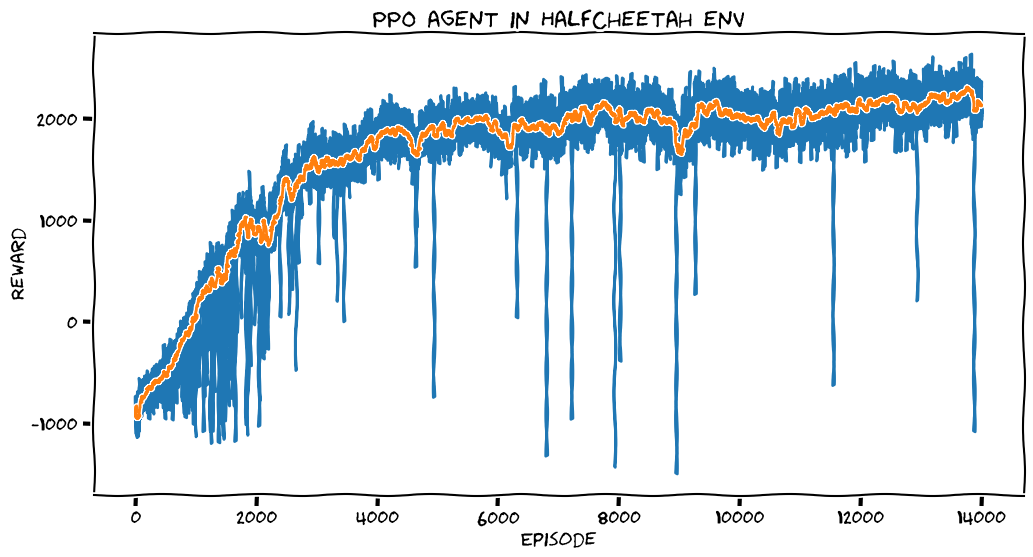

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [31]:
plot_rewards(rewards_history, show_result='PPO agent in HalfCheetah env')

# **Evaluating the PPO Agent in the HalfCheetah-v4 Environment**

In [32]:
# Create environment
%env MUJOCO_GL=egl
testenv = gym.make("HalfCheetah-v4", render_mode="rgb_array")
frames = []

state, info = testenv.reset()
done = False
total_reward = 0

# run the learned PPO agent to evaluate it
while True:
    state = torch.tensor(state, dtype=torch.float).to(device)
    mu, std = agent.actor(state)
    dist = torch.distributions.Normal(mu, std)
    action = dist.sample()
    next_state, reward, terminated, truncated, info = testenv.step(action.detach().cpu().numpy())
    frames.append(testenv.render())
    total_reward += reward
    state = next_state

    if terminated or truncated:
        break

testenv.close()
print(f"Total Reward: {total_reward}")

# Save frames as a video
video_path = "./agent_evaluation.mp4"
imageio.mimsave(video_path, frames, fps=25)

# Display the video
show_video(video_path)

env: MUJOCO_GL=egl
Total Reward: 2123.8106842279326
